In [1]:
%reload_ext autoreload
%autoreload 2

# Transport

## Waveform generation

In [2]:

import numpy as np
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

from models.surface_trap import SurfaceTrap
from pathlib import Path



_dir = Path('.').resolve() / 'data'

trap = SurfaceTrap()

axial = freq_to_curv(1e6, ion=Ca40)
rtilt = 8e7

n_samples = 50
x = zpspace(trap.x_ele(2), trap.x_ele(4), n_samples, k=5, gap=1.75)
y0 = 0
z0 = trap.z0

waveform = init_waveform(n_samples, trap.n_electrodes)

objectives = []

# fill objectives per-step
def step_objective(voltages, x):
    return [
        obj.GradientObjective(voltages, trap, x, y0, z0, value=0, ion=Ca40),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='xx', value=axial, ion=Ca40, pseudo=False),
        obj.HessianObjective(voltages, trap, x, y0, z0, entries='yz', value=rtilt, ion=Ca40, pseudo=False),
    ]

for j, x0 in enumerate(x):
    objectives += step_objective(waveform[j], x0)

objectives += [
    obj.VoltageObjective(waveform, 0),
    obj.VoltageObjective(waveform, 10, constraint_type='<='),
    obj.VoltageObjective(waveform, -10, constraint_type='>='),
    obj.SlewRateObjective(waveform, dt=trap.dt, weight=1e4)
    # obj.SlewRateObjective(waveform, value=4e6, dt=trap.dt, constraint_type='<=')  # V/s
]

_ = solver(objectives, verbose=True)
waveform = waveform.value  # get array from cvxpy variable

savename = _dir / 'waveform_transport.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


Compiling step objectives: 100%|██████████| 154/154 [00:00<00:00, 314.28it/s]

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jun 21 11:31:35 AM: Your problem has 600 variables, 2 constraints, and 0 parameters.


(CVXPY) Jun 21 11:31:35 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 11:31:35 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 11:31:35 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 11:31:35 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 21 11:31:35 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jun 21 11:31:35 AM: Applying reduction Dcp2Cone
(CVXPY) Jun 21 11:31:35 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 21 11:31:35 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Jun 21 11:31:35 AM: Applying reduction MOSEK
(CVXPY)

## Analysis

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout

from pytrans.ions import Ca40, Be9

In [4]:
trap = SurfaceTrap()
waveform = np.load(_dir / 'waveform_transport.npy')

Analyse first / middle / last sample

--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[99.9972  0.0003 67.0811]
Gradient [V/m]
[-0.057   0.1025 -0.5027]
Displacement at 1 MHz [um]
[-0.0035  0.0063 -0.0307]
Hessian [V/m2]
[[ 1.6351e+07 -7.2745e+05 -5.5947e+05]
 [-7.2745e+05  6.2881e+08  7.9995e+07]
 [-5.5947e+05  7.9995e+07  5.6383e+08]]
Normal mode frequencies [MHz]
[0.99996 5.58472 6.46141]
Eigenvectors
[[1 0.00107 0.000865]
 [-0.000117 -0.558 0.83]
 [0.00137 -0.83 -0.558]]
Tilt angle of mode 2 (6.46): -146.05°

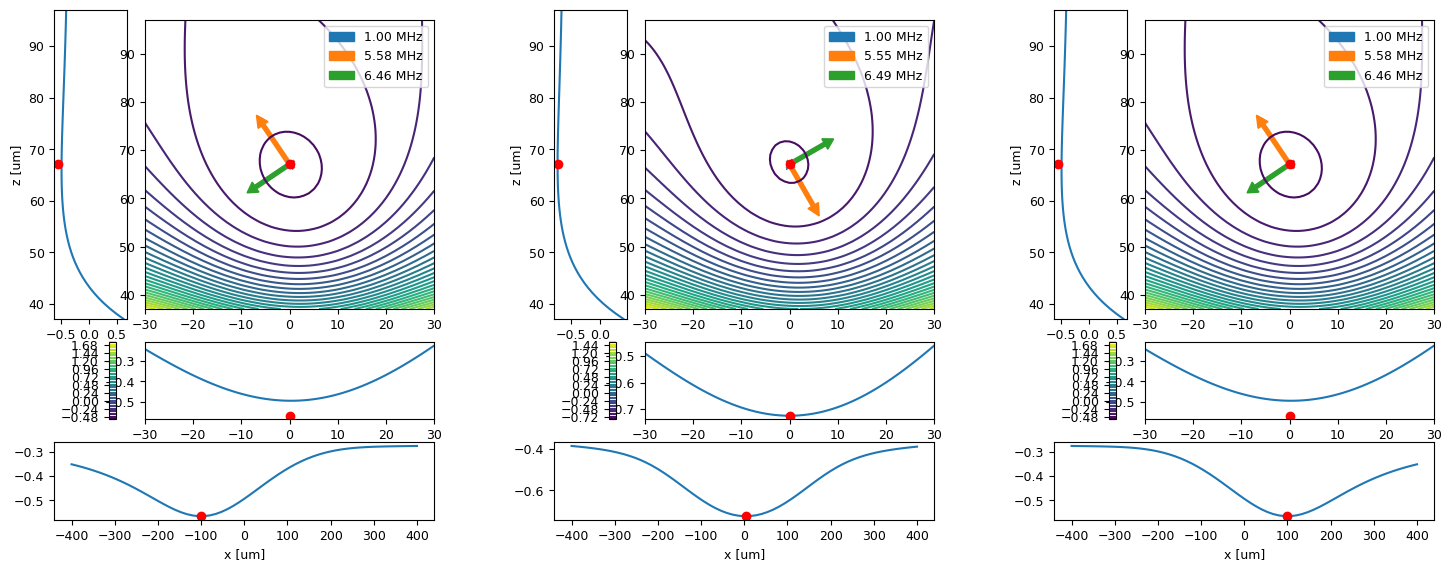

In [52]:
r0 = (0, 0, trap.z0)

fig, axes = plot_potential_make_layout(3)
res1 = analyse_potential(trap, voltages=waveform[0], ions=Ca40, r0=r0, verbose=False, axes=axes[0])
res1 = analyse_potential(trap, voltages=waveform[len(waveform) // 2], ions=Ca40, r0=r0, verbose=False, axes=axes[1])
res2 = analyse_potential(trap, voltages=waveform[-1], ions=Ca40, r0=r0, verbose=False, axes=axes[2])

res2

In [8]:
from pytrans.analysis import analyse_waveform

In [51]:
results = analyse_waveform(trap, waveform, ions=[Ca40, Be9], ion1=Ca40, r0=r0)


Waveform analysis: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


In [44]:
x_eq = np.stack([r.x_eq * 1e6 for r in results], axis=0)
freqs = np.stack([r.mode_freqs * 1e-6 for r in results], axis=0)


In [45]:
x_eq2 = np.stack([r.mode_solver_results.x_eq * 1e6 for r in results], axis=0)


In [46]:
x_eq2.shape

(50, 2, 3)

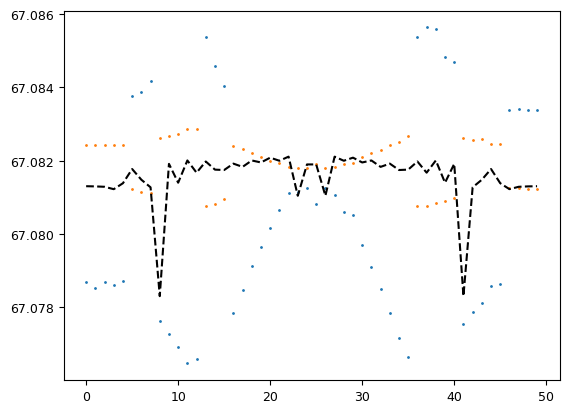

In [50]:
plt.plot(x_eq2[:, :, 2], 'o', ms=1)
plt.plot(x_eq[:, 2], 'k--')


In [14]:
xx = x_eq[:, 0]
freqs.shape

(50, 3)

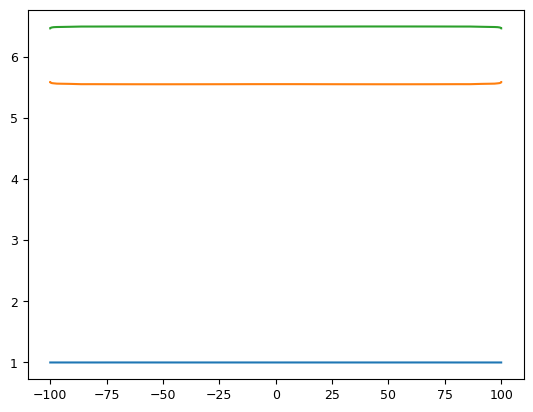

In [15]:

plt.plot(xx, freqs);

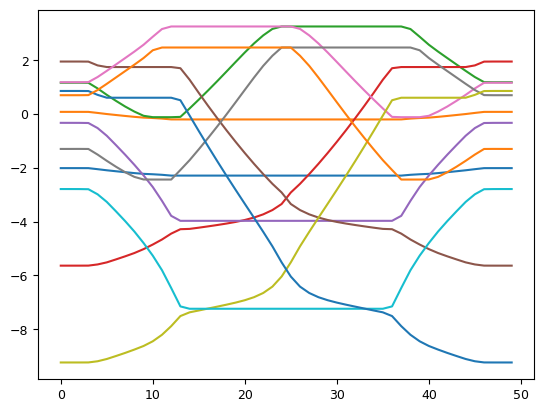

In [16]:
plt.plot(waveform); 

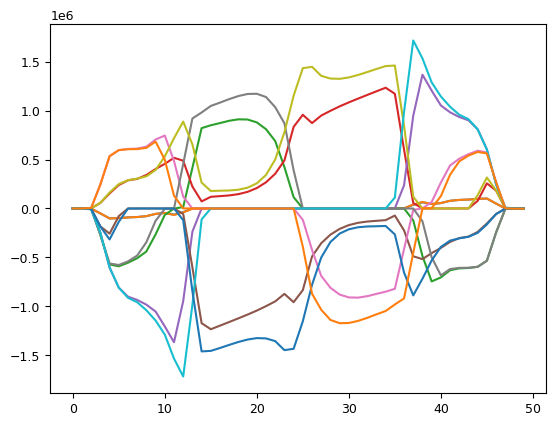

In [17]:
v_diff = np.gradient(waveform, axis=0) / trap.dt
plt.plot(v_diff);

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x320 -pix_fmt rgba -r 50.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y waveform.gif


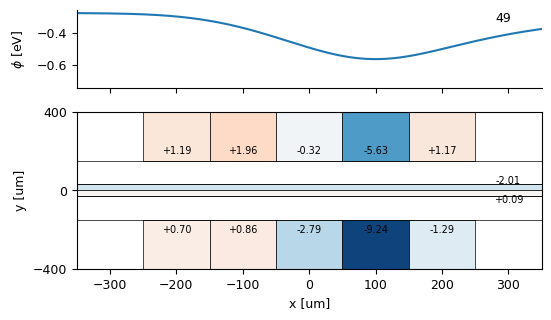

In [18]:
from models.surface_trap.plot import animate_waveform_on_trap

ani = animate_waveform_on_trap(trap, waveform)
ani.save('waveform.gif')


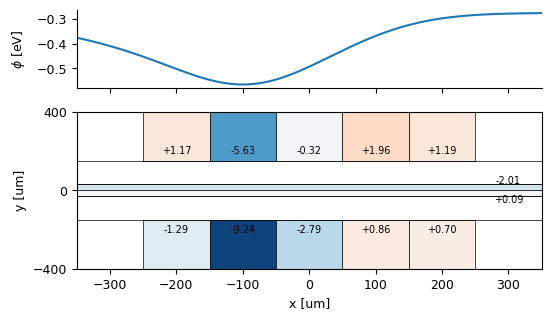

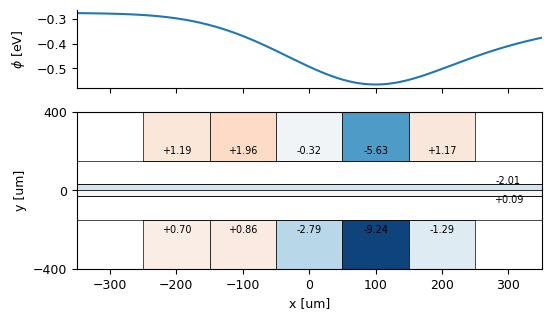

In [19]:
_ = plot_voltages_on_trap(trap, waveform[0])
_ = plot_voltages_on_trap(trap, waveform[-1])


In [ ]:
r = results[0]

In [ ]:
import json

rj = r.to_json()
with open('r0.json', 'w') as fp:
    json.dump(rj, fp)